# Bayesian Statistics and Probabilistic Programming
## Homework - 02
###### Núria Valls, Núria Nievas and Albert Prat

In [1]:
library("ISLR")
library("rjags")
library("R2jags")
library("extraDistr")
library("MASS")
library("mcsm")
library("lattice")
library("rstan")

Loading required package: coda
Linked to JAGS 4.3.0
Loaded modules: basemod,bugs

Attaching package: 'R2jags'

The following object is masked from 'package:coda':

    traceplot


Attaching package: 'mcsm'

The following object is masked from 'package:extraDistr':

    rdirichlet

Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.18.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For improved execution time, we recommend calling
Sys.setenv(LOCAL_CPPFLAGS = '-march=native')
although this causes Stan to throw an error on a few processors.

Attaching package: 'rstan'

The following object is masked from 'package:R2jags':

    traceplot

The following object is masked from 'package:coda':

    traceplot



### Exercise 1

Suppose $y$ has a binomial distribution with parameters $n$ and $p$, and we are interested in the log-odds value $\theta = \log \frac{p}{(1 − p)}$. Our prior for $\theta$ is that $\theta ∼ N(\mu, \sigma)$. It follows that the posterior density of $\theta$ is given, up to a proportionality constant, by

$$ g(\theta|y) \propto \frac{exp(y\theta)}{(1+exp(\theta)^n)} exp\left( - \frac{(\theta - \mu)^2}{2\sigma^2} \right) $$

More concretely, suppose we are interested in learning about the probability that a special coin lands heads when tossed. A priori we believe that the coin is fair, so we assign $\theta$ a $N(0, 0.25)$ prior. We toss the coin $n = 5$ times and obtain $y = 5$ heads.

#### (1) Using a normal approximation to the posterior density, compute the probability that the coin is biased toward heads (i.e., that $\theta$ is positive).

The objective is to compute a normal distribution such that:

$$ g(\theta|y) \propto N(\theta_0, (I(\theta_0))^{-1}) $$

Where $\theta_0$ is the $\theta$ such that the first derivative of the log target function is zero. And $I(\theta_0)$ is the second derivative of the log target function.

In order to compute it we first have to look at the first and second derivatives of the log posterior function ($g(\theta|y)$):

$$ q(\theta)=\log(g(\theta|y)) = y\theta - n\cdot \log(1+e^\theta) - \frac{(\theta - \mu)^2}{2\sigma^2} $$

$$ q'(\theta)= \frac{dq}{d\theta} = y-\frac{n\cdot e^\theta}{1+e^\theta} - \frac{\theta - \mu}{\sigma^2} $$

$$q''(\theta)=\frac{d^2 q}{d\theta^2}=-\frac{n·e^\theta(1+e^\theta)-n·e^{2\theta}}{(1+e^\theta)^2}-\frac{1}{\sigma^2} = \frac{-n·e^\theta}{(1+e^\theta)^2}-\frac{1}{\sigma^2}$$

Now we can compute $\theta_0$ as:

$$ q'(\theta) = 0 \rightarrow \theta_0 = 0.4783 $$

And also $I(\theta_0)$ as:

$$ q''(\theta_0) = -5.18115 \rightarrow I(\theta_0)^{-1} = 0.193 $$

Now we can define the normal approximation as:

$$ N(4.783, 0.193) $$

Which we will compute in the following code.

In [4]:
mean <- 0
var <- 0.25
sd <- sqrt(var)
n <- 5
y <-5

posterior <- function(theta){exp(y*theta)*exp(-((theta-mean)^2)/(2*(sd^2)))/(1+exp(theta))^n}

dq <- function(theta){y-(n*exp(theta)/(1+exp(theta)))-(theta-mean)/(sd^2)}
approx.mean <- uniroot(dq,c(-2,2))$root
approx.mean

ddq <- (-n*(exp(approx.mean))/(1+exp(approx.mean))^2)-1/sd^2
approx.variance <- 1/abs(ddq) 
approx.variance
approx.sd <- sqrt(approx.variance)

[1] 0.4783142

[1] 0.1930075

Let's now plot the posterior and the resulting approximation function.

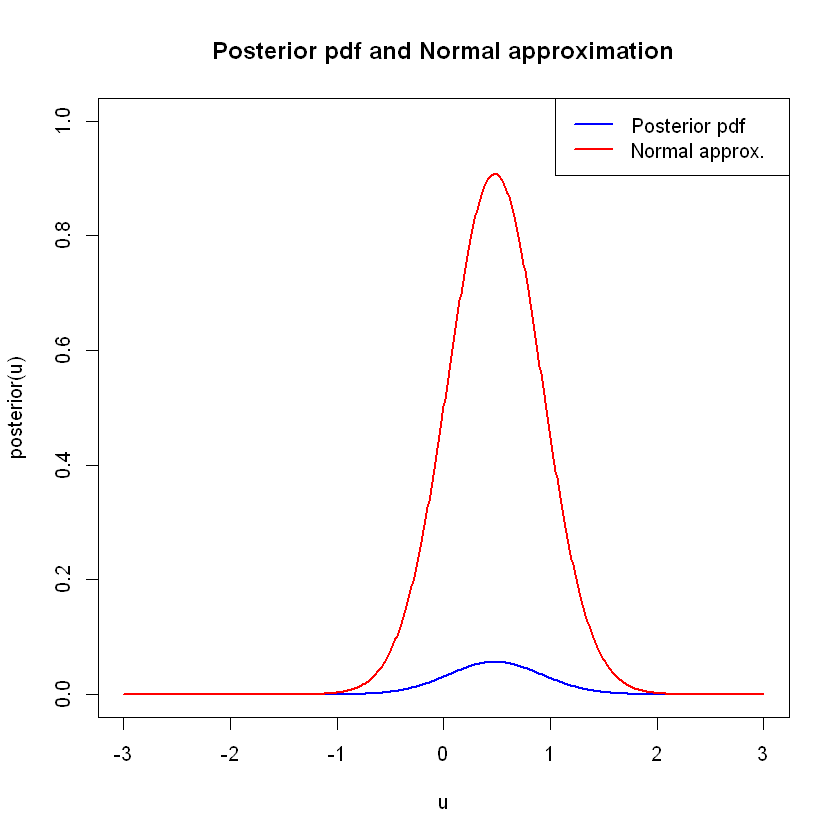

In [7]:
u <- seq(-3,3,0.01)
plot(u,posterior(u),"l",lwd=2,col="blue",main="Posterior pdf and Normal approximation",ylim=c(0,1))
lines(u,dnorm(u,mean=approx.mean,sd=approx.sd),col="red",lwd =2)
legend("topright",legend=c("Posterior pdf","Normal approx."),lwd=2,col=c("blue","red"))

As it can be seen, the two functions are not in the same scale, in order to solve this we can normalize the posterior function in the following way:

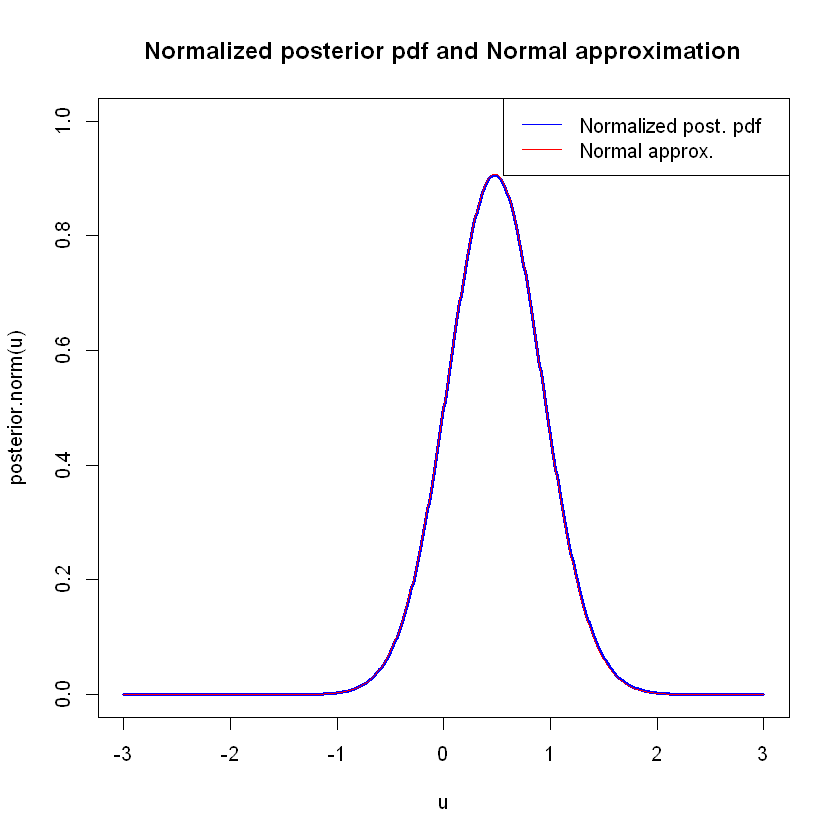

In [8]:
norm <- integrate(posterior,-3,3)$value
posterior.norm <- function(theta){posterior(theta)/norm}

u <- seq(-3,3,0.01)
plot(u,posterior.norm(u),"l",lwd=2.5,col="blue",main="Normalized posterior pdf and Normal approximation",ylim=c(0,1))
lines(u,dnorm(u,mean=approx.mean,sd=approx.sd),col="red",lwd=1.5)
legend("topright",legend=c("Normalized post. pdf","Normal approx."),lwd=1.5,col=c("blue","red"))

Let's check now the probability that the coin toss heads and see if it is biased or not. We will look at the integrated probability from $-\inf$ to 0, if the value is bigger that $0.5$ means the probability is biased as we consider positive probabilities as heads. 

In [9]:
prob.tails <- pnorm(0,approx.mean,approx.sd)
prob.heads <- 1 - prob.tails
prob.heads

[1] 0.8618668

As the probability of heads is far bigger than $0.5$, we can conclude that the probability of the coin is biased towards heads. In other words, if this probability was $0.5$, it would mean that half of the distribution is before $0$. As a result, the probability of $\theta_0$ being negative would be the same as the probability that $\theta_0$ takes positive values, which is not the case.

#### (2) Using the prior density as a proposal density, design a rejection algorithm for sampling from the posterior distribution. Using simulated draws from your algorithm, approximate the probability that the coin is biased toward heads.

Following the Rejection sampling algorithm, we are given the posterior $g(\theta|y)$ as target distribution we are going to sample from, and the prior density function $p(\theta)$ which will be $\theta ∼ N(0, 0.25)$.

First we need to determine a constant $c$ such that:

$$ g(\theta | y) \leq c \cdot p(\theta) $$


In [10]:
prior <- function(theta){dnorm(theta, mean, sd)}
c.values <- function(theta){posterior(theta)/prior(theta)}

N <- 100000
u <- seq(-3,3,length=N)
c <- max(c.values(u))
c

[1] 0.9830007

What we mainly do for rejection sampling is randomly sample from a uniform disribution on each axis. Then we look at whether or not the point created for these sampled pairs falls under our target posterior or not. If it is under we accept the sample, otherwise we reject it.

In order to do so, first we need to define the two samples: $u$ from our prior $p(\theta)$ and $v$ following a uniform distribution $Unif(0,1)$. Then, in order to check if the uniform $v$ sample is under our posterior we need to make sure that:

$$ v < \frac{g(\theta)}{c\cdot p(\theta)} $$

Then only those samples from the uniform distribution that accomplish the previous statement will be kept, the other ones will be rejected.

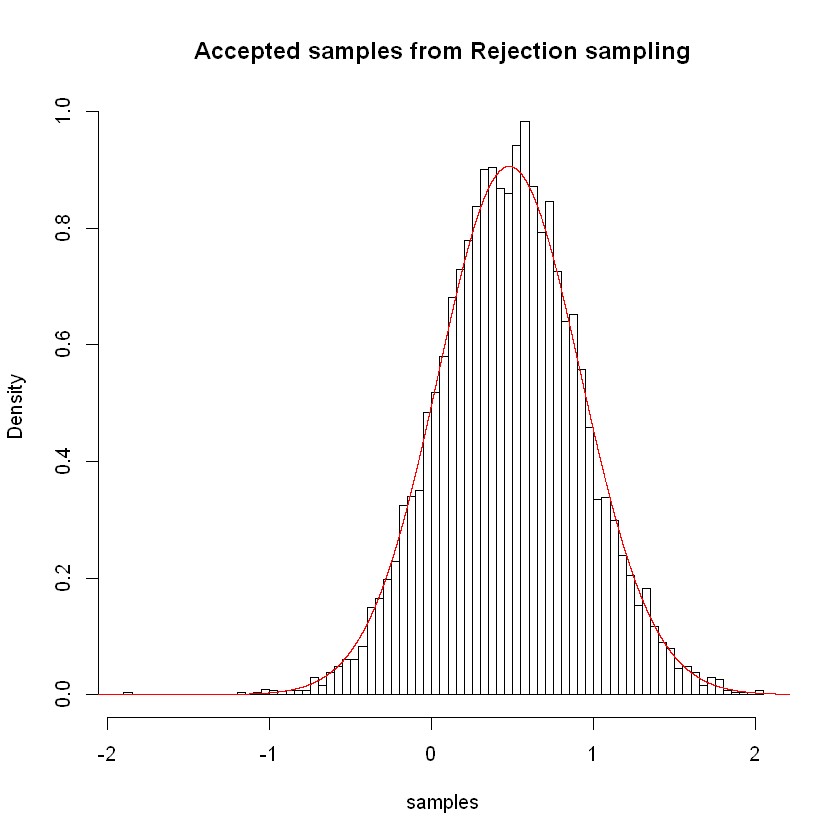

In [11]:
u.sample  <- rnorm(N, mean, sd)
v.sample <- runif(N)

accept <- posterior(u.sample)/(c*prior(u.sample))
samples <- u.sample[v.sample<accept]

library(MASS)
hist(samples, main="Accepted samples from Rejection sampling",nclass=100, freq=FALSE)
lines(u,posterior.norm(u), col="red")

Now that we have the approximation of the posterior density function, the probability that the coin is biased towards heads can be computed as the sum of those samples that have a positive value (are evaluated as heads).

In [12]:
prob.heads <- sum(samples > 0)/length(samples)
prob.heads

[1] 0.8690533

As the computed value for the probability of heads is clearly above $0.5$ one can say that the coin is biased towards heads.

#### (3) Using the prior density as a proposal density, simulate values from the posterior distribution using the SIR algorithm. Approximate the probability that the coin is biased toward heads.

The main idea behind the SIR algorithm is to take a simulated sample of draws from one distribution $p(\theta)$ (our prior), and using these draws to produce a sample from a different distribution $g(\theta)$ (our posterior).

In order to implement the algorithm, first we need to define the following function that will define the so called weights:

$$ w(\theta) = \frac{g(\theta)}{p(\theta)} $$

In [13]:
N<-10000

prior.sample <- rnorm(N, mean , sd)
weights.sum <- sum(posterior(prior.sample)/prior(prior.sample))
weights <- posterior(prior.sample)/(prior(prior.sample)*weights.sum)

Once we have the weights we must resample the prior $p$ distribution with the probabilities of each of the weights, calculated as follows:

$$ prob_i = \frac{w_i}{\sum_{j=0}^n w_j} $$

Where $0 \leq i\leq n$ and $n$ is the resampling size.

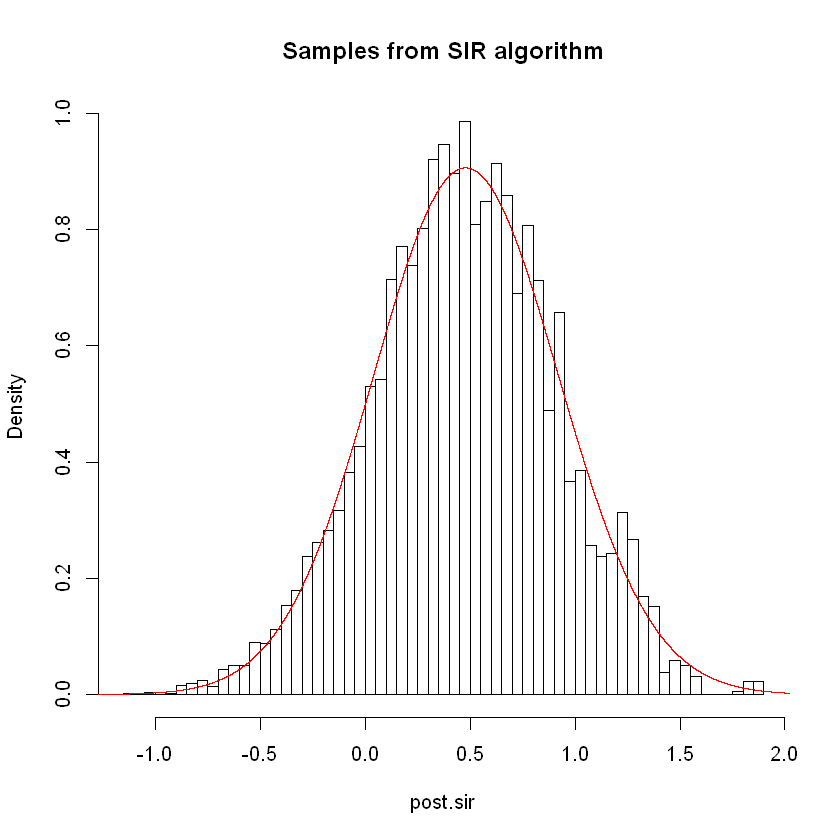

In [14]:
idx <- sample(1:N, size = N, prob = weights, replace = TRUE)
post.sir <- prior.sample[idx]

hist(post.sir, main="Samples from SIR algorithm", nclass=100, freq=FALSE)
lines(u,posterior.norm(u), col="red")

Now that we have found our posterior approximation using the SIR algorithm, we can compute the probability of heads by looking at those samples that account for a positive number (evaluated as heads):

In [15]:
prob.heads <- sum(post.sir > 0)/length(post.sir)
prob.heads

[1] 0.8621

As the computed value for the probability of heads is clearly above $0.5$ one can say that again, the coin is biased towards heads.

### Exercise 2
In 1986, the space shuttle Challenger exploded during takeoﬀ, killing the seven astronauts aboard. The explosion was the result of an O-ring failure, a splitting of a ring of rubber that seals the parts of the ship together. The accident was believed to have been caused by the unusually cold weather (31ºF or 0ºC) at the time of launch, as there is reason to believe that the O-ring failure probabilities increase as temperature decreases. Data on previous space shuttle launches and O-ring failures are given in the dataset challenger provided with the mcsm package.
#### (1) Fit this dataset with classic-frequentist logistic regression using the classic MLE's for $\alpha$ and $\beta$, along with standard errors. Estimate the probabilities of failure at 60ºF, 50ºF and 40ºF.
Let's read our _challenger_ data.

In [3]:
data("challenger")
df <- challenger
head(df,3)

oring,temp
1,53
1,57
1,58


The first column is a dummy variable which takes value 1 if the experiment failed. The second column is the temperature at which the experiment was done. Let's fit the Logistic Regression of variable _temp_ upon whether the experiment was a failure or not (_O-ring_ variable).

In [15]:
lr.model <- glm(oring ~ temp, family = binomial(), data = challenger)

Let's see the estimated paremeters $\alpha$ and $\beta$:

In [16]:
summary(lr.model)


Call:
glm(formula = oring ~ temp, family = binomial(), data = challenger)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0611  -0.7613  -0.3783   0.4524   2.2175  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept)  15.0429     7.3786   2.039   0.0415 *
temp         -0.2322     0.1082  -2.145   0.0320 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 28.267  on 22  degrees of freedom
Residual deviance: 20.315  on 21  degrees of freedom
AIC: 24.315

Number of Fisher Scoring iterations: 5


According to this model, $\alpha=15.0429$ and $\beta=-0.2322$. Both parameters seem to be significant to the success or not of the take-off. Notice that both parameters are significant with a 95% of confidence because $\text{Pr (> }\mid t\mid)<0.05$.

To be able to perform some kind of predictions we need the following relationship:

$$
P(Y_i=1|x_i) \equiv p(x_i) = \text{Logistic} (\alpha+\beta x_i) = \frac{\text{exp}(\alpha+\beta x_i)}{1+\text{exp}(\alpha+\beta x_i)}
$$

Since we want to predict the probability of failure given a temperature, let's see the same equation applied to our model for the 60ºF case (for the other temperatures the same apply)

$$
P(\text{O'ring}=1\text{ | temp}=60º\text{F}) \equiv p(60ºF) = \text{Logistic} (\hat{\alpha}+\hat{\beta} x_i) = \frac{\text{exp}(\hat{\alpha}+\hat{\beta} x_i)}{1+\text{exp}(\hat{\alpha}+\hat{\beta} x_i)}
$$

substituting $\hat{\alpha}$ and $\hat{\beta}$ for our results. Let's take both parameters and estimate this probability:

In [17]:
alpha = lr.model$coef[1]
beta = lr.model$coef[2]

p <- function(x, alpha, beta) {
    return(exp(alpha+beta*x)/(1+exp(alpha+beta*x)))
}

pred = data.frame(temp = c(40, 50, 60))
for (i in seq_along(pred$temp)) {
    #p = exp(alpha+beta*df$temp[i])/(1+exp(alpha+beta*df$temp[i]))
    pred[i,"prob"] = round(p(pred$temp[i], alpha, beta)[[1]],3)
}

pred

temp,prob
40,0.997
50,0.969
60,0.753


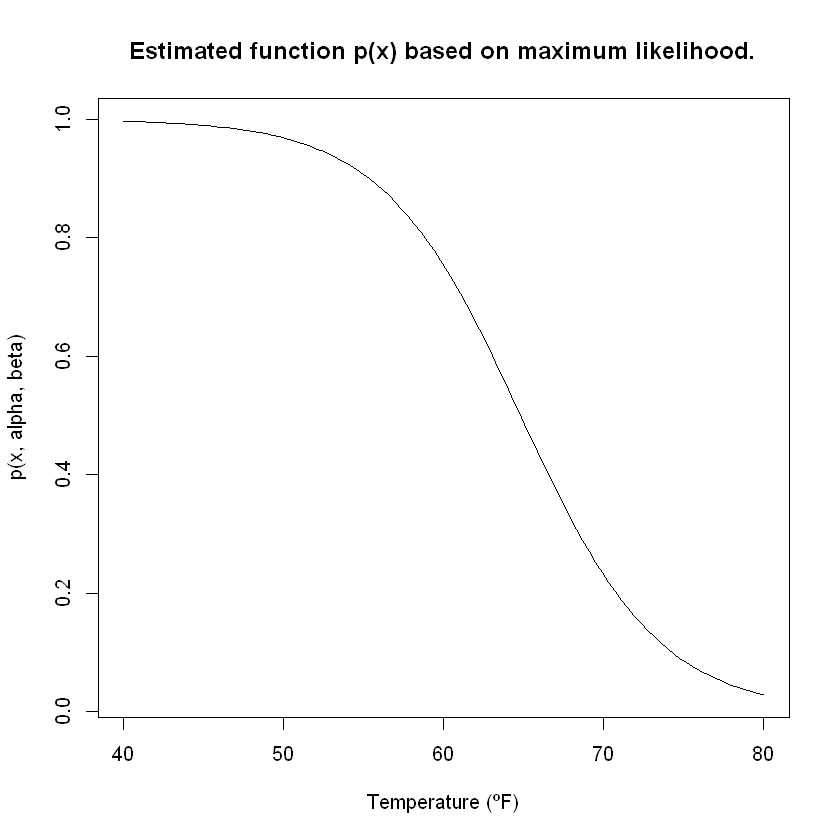

In [30]:
x=seq(40,80,length=100)
plot(x, p(x, alpha, beta), main = 'Estimated function p(x) based on maximum likelihood.', type="l", xlab="Temperature (ºF)")

According to the model fitted, the probability of a failure increases with lower temperatures. According to this frequentist approach, the hypothesis "the space shuttle exploted because of the unusual cold wheather" would be accepted.

#### (2) Bayesian version: As suggested in Robert, Casella (2004), pag. 282, take a flat prior for $\beta$ and, for $\alpha$, consider it the logarithm of a new parameter:

$$\alpha = \log(w),\quad \text{where } w \sim \text{Exp} (\frac{1}{s}), \quad s>0.$$

We first define the maximum likelihood estimators of alpha and beta:

In [22]:
# Agafem els estimadors anteriors

mle.alpha = lr.model$coef[1]
mle.beta = lr.model$coef[2]
mle.var.beta <- summary(lr.model)$cov.scaled[2, 2]

Now, we define all the functions we will need to implement the Metropolis-Hastings algorithm and the algorithm.

We use a normal distribution to estimate $\beta$ as it is suggested in Robert and Casella 2004.

In [23]:
alpha.prior <- function(alpha) {
    gamma <- 0.577216
    s <- exp(mle.alpha + gamma)
    h <- (1/s)*exp(alpha)*exp((-1/s)*exp(alpha))
    return(h)
}

beta.prior <- function(beta) {
    z <- dnorm(beta, mean = mle.beta, sd = sqrt(mle.var.beta))
    return(z)
}

g.alpha.beta <- function(alpha, beta) {
    g <- alpha.prior(alpha)*beta.prior(beta)
    return(g)
}

In [24]:
likelihood <- function(alpha, beta) {
    p = 1
    for (i in 1:length(df)) {
        p = p*(exp(alpha+beta*df$temp[i])/(1+exp(alpha+beta*df$temp[i]))**df$oring[i])*(1/(1+exp(alpha+beta*df$temp[i])))**(1-df$oring[i])
    }
    #p <- 1 - 1 / (1 + exp(alpha + beta * x))
    #lik <- exp(sum(dbinom(y, size=1, prob=p, log=TRUE)))
    return(p)
}

posterior <- function(alpha, beta) {
    return(likelihood(alpha,beta)*alpha.prior(alpha))
}


In [25]:
run.metropolis <- function(iterations){
    gamma <- 0.577216
    s <- exp(mle.alpha + gamma)
    epsilon<-1.0e-8
    chain <- array(dim = c(iterations,2))
    alpha0 <- log(rexp(1, 1/s))
    beta0 <- rnorm(1,mle.beta, sqrt(mle.var.beta))
    chain[1,] <- c(alpha0,beta0)
    for (i in 2:iterations){
        alpha0 <- log(rexp(1, 1/s))
        beta0 <- rnorm(1,mle.beta, sqrt(mle.var.beta))
        chain[i,] <- c(alpha0,beta0)
      
        pp <- posterior(chain[i-1,1], chain[i-1,2])

        if(pp<epsilon)    # avoid division by 0
            probab<-1
        else
            r <- posterior(chain[i,1], chain[i,2])/pp
            probab<-min(1,r)
        
        if (runif(1) >= probab) {
            chain[i,] <- chain[i-1,]
        }
    }
    return(chain)
}

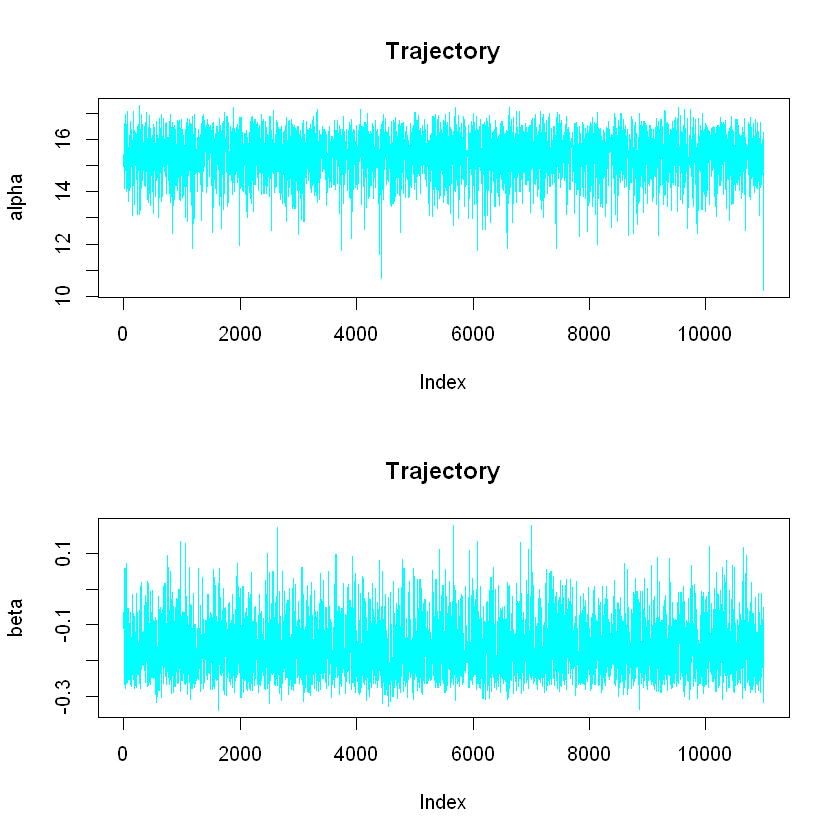

In [26]:
Chain.Length<-15000

chain<-run.metropolis(Chain.Length)
burnIn<-4000
chain1<-chain[(burnIn+1):nrow(chain),]
old.par<-par(mfrow=c(2,1))
plot(chain1[,1],type="l",col="cyan",ylab="alpha",main="Trajectory")
plot(chain1[,2],type="l",col="cyan",ylab="beta",main="Trajectory")
par(old.par)

In [27]:
pred = data.frame(temp = c(40, 50, 60))
alpha.beta <- chain[Chain.Length, ]

data.frame("alpha" = alpha.beta[1], "beta" = alpha.beta[2])

for (i in seq_along(pred$temp)) {
    pred[i,"prob"] = round(p(pred$temp[i], alpha.beta[1], alpha.beta[2])[[1]],3)
}

pred

alpha,beta
15.11692,-0.1680768


temp,prob
40,1.000
50,0.999
60,0.994


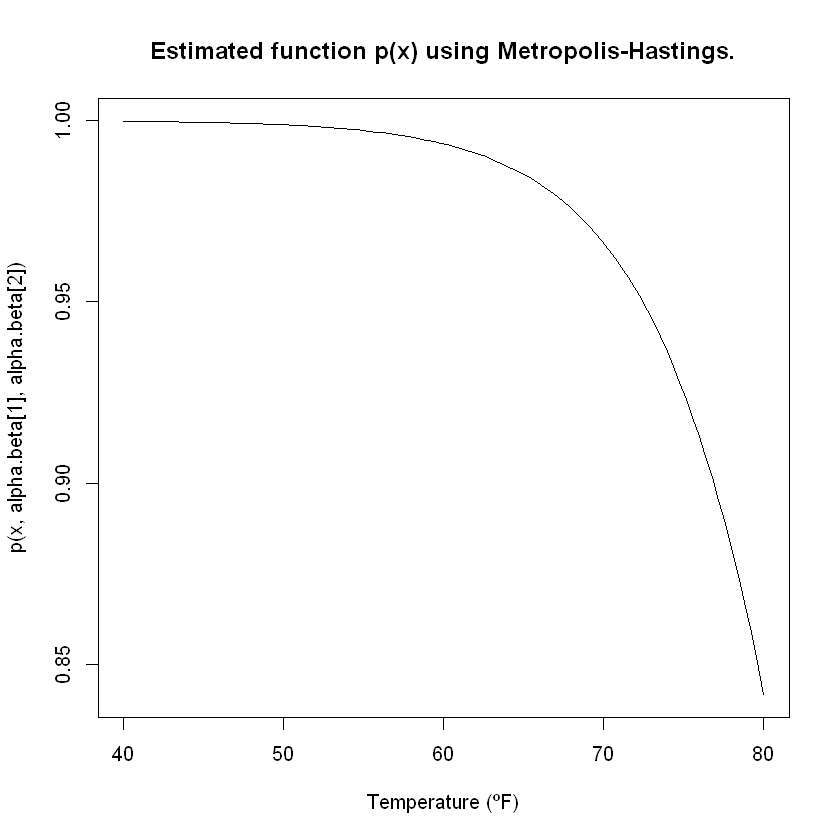

In [31]:
x=seq(40,80,length=100)
plot(x, p(x, alpha.beta[1], alpha.beta[2]), main = 'Estimated function p(x) using Metropolis-Hastings.', type="l", xlab="Temperature (ºF)")

#### (3) (Bivariate product slice sampler) Write the likelihood of this logistic regression model as a product of n functions and follow the derivations in R.C. (2010), pag. 220. 


#### Function challenge in the mcsm package implements a bivariate product slice sampler for this example. 
#### List (i.e., understand the underlying algebra & document/improve the code) the function (Warning: Robert-Cassella switch notations $(\alpha, \beta) \rightarrow (a, b)$ in mid-example). 

We introduce normal $N(0, \sigma^{2})$ priors on both alpha and beta (a and b). The modification on the slice sampler is minimal in that both uniform distributions above are replaced with truncated normals $N(0, \sigma^{2})$, the truncation intervals being those used above. The code extracted from Robert-Cassela 2010 is:

In [32]:
challenge<-function(Nsim = 10^4) 
{
    rtrun = function(mu = 0, sigma = 1, minn = -Inf, maxx = Inf) {
        qnorm(pnorm(minn, mean = mu, sd = sigma) + (pnorm(maxx, 
            mean = mu, sd = sigma) - pnorm(minn, mean = mu, sd = sigma)) * 
            runif(1))
    }
    x = challenger[, 2]
    y = challenger[, 1]
    n = length(x)
    a = b = rep(0, Nsim)
    a[1] = glm(challenger[, 1] ~ challenger[, 2])$coef[1]
    b[1] = glm(challenger[, 1] ~ challenger[, 2])$coef[2]
    meana = 0
    sigmaa = 5
    meanb = 0
    sigmab = 5/sd(x)
    for (t in 2:Nsim){
        uni=runif(n)*exp(y*(a[t-1]+b[t-1]*x))/(1+exp(a[t-1]+b[t-1]*x))
        mina=max(log(uni[y==1]/(1-uni[y==1]))-b[t-1]*x[y==1])
        maxa=min(-log(uni[y==0]/(1-uni[y==0]))-b[t-1]*x[y==0])
        a[t]=rtrun(0,sigmaa,mina,maxa)
        minb=max((log(uni[y==1]/(1-uni[y==1]))-a[t])/x[y==1])
        maxb=min((-log(uni[y==0]/(1-uni[y==0]))-a[t])/x[y==0])
        b[t]=rtrun(0,sigmab,minb,maxb)
    }
    list(a = a, b = b)
}

In [33]:
burnIn<-4000

params<-challenge()
alpha3<-params$a
beta3<-params$b

alpha3.mean<-mean(alpha3[-(1:burnIn)])
beta3.mean<-mean(beta3[-(1:burnIn)])

pred = data.frame(temp = c(40, 50, 60))
alpha.beta <- chain[Chain.Length, ]

data.frame("alpha" = alpha3.mean, "beta" = beta3.mean)

for (i in seq_along(pred$temp)) {
    pred[i,"prob"] = round(p(pred$temp[i], alpha3.mean, beta3.mean)[[1]],3)
}

pred

alpha,beta
0.485253,-0.1263235


temp,prob
40,0.010
50,0.003
60,0.001


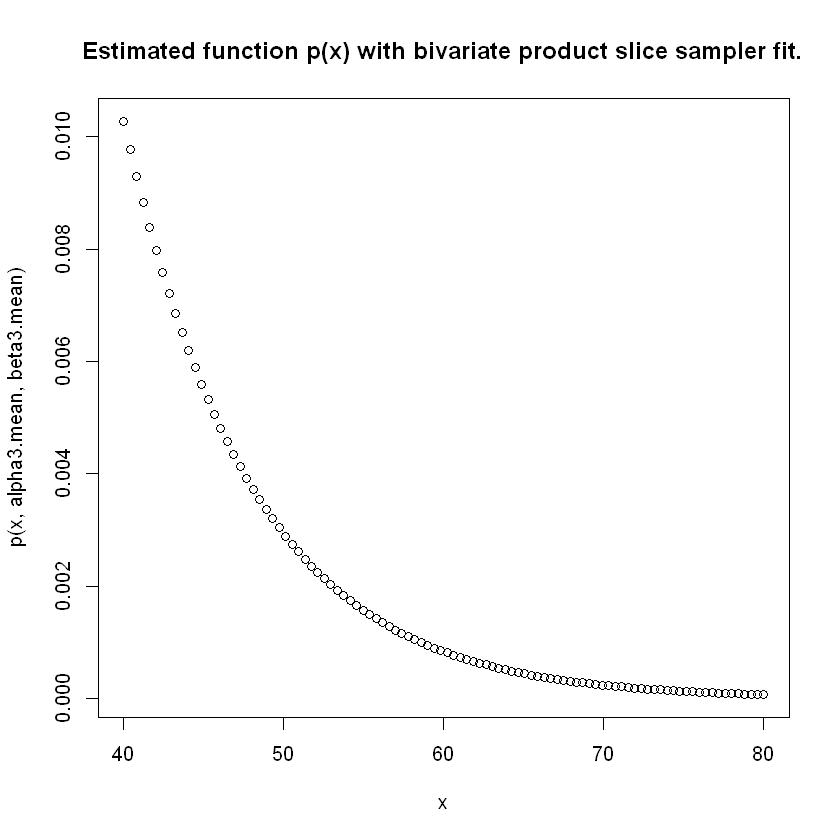

In [35]:
x=seq(40,80,length=100)
plot(x, p(x, alpha3.mean, beta3.mean), main = 'Estimated function p(x) with bivariate product slice sampler fit.')

### Exercise 3
#### (1) Fit the following two classic, frequentist linear models. Describe the results, such as significance of predictors and overall quality of predictions.
$$\text{Credit.lm1 <- lm(Balance ~ Limit + Income, data=Credit)}$$
$$\text{Credit.lm1 <- lm(Balance ~ Student + Limit, data=Credit)}$$

The aim here is to predict which customers will default on their credit card debt. We will use the variable `Balance` as a proxy to measure whether a customer will default or not. `Balance` is the average credit card balance in dollars.

We will be regressing linear this variable `Balance` upon both (1)`Limit` and `Income` and (2) `Student` and `Limit`. Let's learn about this variables:
- `Limit`: credit limit of the bank account (also in dollars).
- `Income`: income in \$10,000's (ten thousand's of dollars).
- `Student`: A factor with levels No and Yes indicating whether the individual was a student or not.

Let's read the data:

In [21]:
data("Credit")
df <- Credit

We fit both models as stated and analyze the results for both models:

In [22]:
Credit.lm1 <- lm(Balance ~ Limit + Income, data = df)
Credit.lm2 <-lm(Balance ~ Student + Limit, data = df)

Therefore, what we are actually fitting is those models:
$$\text{Balance} = \beta_0 + \beta_1 \text{Limit} + \beta_2 \text{Income} + u$$
$$\text{Balance} = \beta_0 + \beta_1 \text{Student} + \beta_2 \text{Limit} + u$$

Let's now look at which values for $\beta_0$, $\beta_1$ and $\beta_2$ we have learned fitting the model:

In [5]:
summary(Credit.lm1)


Call:
lm(formula = Balance ~ Limit + Income, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-232.79 -115.45  -48.20   53.36  549.77 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -385.17926   19.46480  -19.79   <2e-16 ***
Limit          0.26432    0.00588   44.95   <2e-16 ***
Income        -7.66332    0.38507  -19.90   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 165.5 on 397 degrees of freedom
Multiple R-squared:  0.8711,	Adjusted R-squared:  0.8705 
F-statistic:  1342 on 2 and 397 DF,  p-value: < 2.2e-16


We can conclude several things from this summary. The first thing we have to look at is at our $R^2$. Recall that $R^2$ is a measure of explainability, that is, $1-\frac{SSR}{SST}$ where:

- $SSR$ stands for "Sum Squares of the Residuals" and is defined as $\sum_{i=1}^n (y_i - \hat{y}_i)^2$.
- $SST$ stands for "Sum Squares Total" and is defined as  $\sum_{i=1}^n (y_i - \bar{y}_i)^2$.

In other words, $R^2$ tells us about which percentage of data is explained by our model. Moreover, it can also be used as a measure of quality of our predictions. In our case, this number is 0.8711 over 1, which is high enough. Moreover, according to our model $\beta_0$, $\beta_1$ and $\beta_2$ are significant with more than a 99% of confidence. We can see that by looking at the last column of this summary. These 3 stars near the three estimates $\beta_0$, $\beta_1$ and $\beta_2$ mean that we are rejecting the null hypotheses

$$H_0: \beta_i = 0 \text{ for } i = 0,1,2$$

As a consequence, variables `Limit` and `Income` are significant when trying to explain if a person will default or not. Moreover, we could relate linearly both (1)`Balance` and `Limit` and (2)`Balance` and `Income` using the paramaters estimated $\beta_1$ and $\beta_2$ respectively.

Let's now look at the second model:

In [6]:
summary(Credit.lm2)


Call:
lm(formula = Balance ~ Student + Limit, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-637.77 -116.90    6.04  130.92  434.24 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -3.347e+02  2.307e+01  -14.51   <2e-16 ***
StudentYes   4.044e+02  3.328e+01   12.15   <2e-16 ***
Limit        1.720e-01  4.331e-03   39.70   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 199.7 on 397 degrees of freedom
Multiple R-squared:  0.8123,	Adjusted R-squared:  0.8114 
F-statistic: 859.2 on 2 and 397 DF,  p-value: < 2.2e-16


Similar things happen here. The first remark is that $R^2$ is lower than in the first model ($R^2=0.8123$ here). For the other variables we can see that according to this model variables `StudentsYes` (dummy variable for students) and `Limit` also are significant when explaining `Balance` with a 99% of confidence.

Let's now perform a re-assignment in order to work in the Bayesian paradigm. What we called $\beta$ now will be $\theta$. These parameters also follow a distribution, therefore, we will estimate a posterior distribution for each $\theta$ present in each model.

#### (2) Using JAGS prepare Bayesian versions for _Credit.lm1_ and _Credit.lm2_, with a discussion of the possible priors.
To model a problem using Bayesian Statistics we need both a likelihood and a prior. Our likelihood corresponds to the distribution from which our dependent variable `Balance` could be drawn. Let's plot an histogram of `Balance` and see which likelihod we can consider:

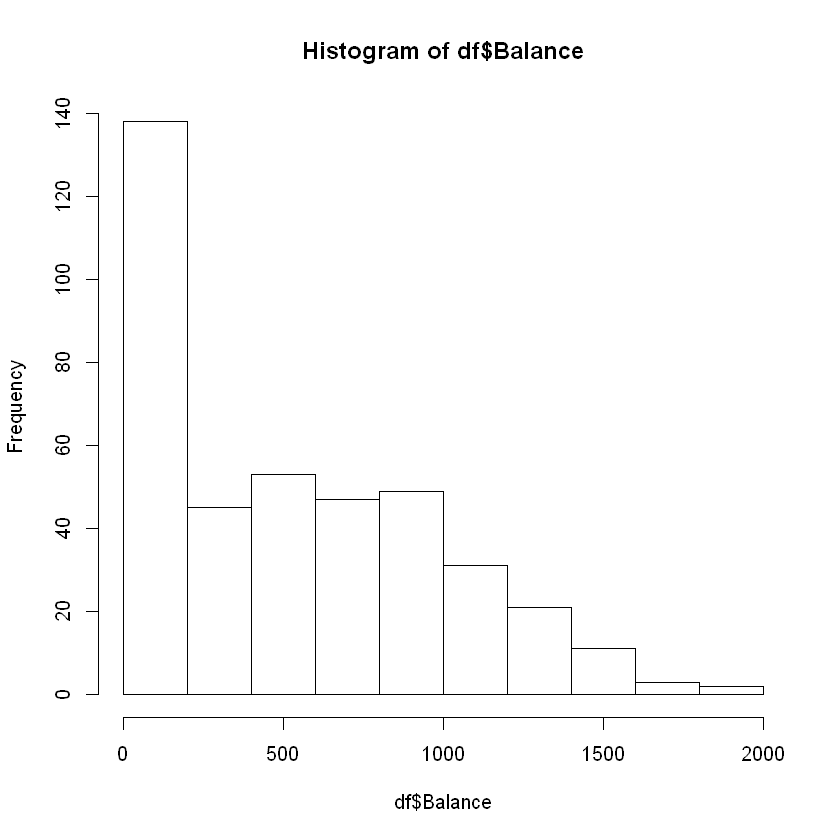

In [7]:
hist(df$Balance)

We have to think about which distribution would be able to generate our `Balance` variable. We may think, for instance, of a Possion or an exponential distribution. Even though it does not make much sense to treat this data as Gaussian, we will assume that `Balance` follows a Normal distribution for practical purposes (as discussed in class). For the dispersion parameter of the normal distribution, which we will call $\tau$, we'll suppose that is defined as $\tau = \frac{1}{\sigma^2}$. We will also estimate $\sigma$ using JAGS.

Let's perform a reassignement of the three parameters $\beta$ (in the frecuentist approach):
-  $\beta_0 = \theta_0  $
-  $\beta_1 = \theta_1  $
-  $\beta_2 = \theta_2  $

For the parameters $\theta$ we will consider two different priors:
- Uniform prior (non-informative)
- Normal prior

Taking a non-informative prior would be like having no previous information about our parameters. For this case, we will just take a uniform distribution. 

The second prior we'll take is a normal one. A linear regression model like the one we used assumes that those parameters are normal distributed with mean $\hat{\theta}$ and standard deviation $\hat{SE}$ (standing for standard error). Those parameters are given by the `R` summary of the regression. Therefore, it makes sense to use this knowledge as the prior knowledge.

Let's run JAGS for the first model we fitted. Recall that we were fitting:

$$\text{Balance} = \beta_0 + \beta_1 \text{Limit} + \beta_2 \text{Income} + u$$

stored in `Credit.lm1`.

In [11]:
s1 <- summary(Credit.lm1)
s1


Call:
lm(formula = Balance ~ Limit + Income, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-232.79 -115.45  -48.20   53.36  549.77 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -385.17926   19.46480  -19.79   <2e-16 ***
Limit          0.26432    0.00588   44.95   <2e-16 ***
Income        -7.66332    0.38507  -19.90   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 165.5 on 397 degrees of freedom
Multiple R-squared:  0.8711,	Adjusted R-squared:  0.8705 
F-statistic:  1342 on 2 and 397 DF,  p-value: < 2.2e-16


Let's begin with the Non-Informative Prior (NIP) case (i.e. taking as prior distributions for our $\theta$'s a $\text{U}[0,1]$). Recall that, for JAGS, the likelihood distribution is defined observation by observation and dispersion measures are understood as precisions ($\frac{1}{\sigma}$). Additionally, notice we also take a NIP for $\sigma$. $\sigma \sim \text{U}[0,30]$

In [28]:
N<-length(row.names(df))

cat("model {for (i in 1:N){ 
                y[i] ~ dnorm(y.hat[i], tau)
                y.hat[i] <- theta0 + theta1 * x1[i] + theta2 * x2[i] 
                }

            theta0 ~ dunif(0,1) 
            theta1 ~ dunif(0,1) 
            theta2 ~ dunif(0,1) 
            tau <- pow(sigma, -2) 
            sigma ~ dunif(0,30)  
            } ",file="ex3NIP.jag")
ex3.NIP <- list("x2" = df$Income, "x1" = df$Limit, "y" = df$Balance, "N" = N)

In [29]:
ex3.NIP.jags<-jags(data=ex3.NIP, n.chains=3,
        parameters.to.save=c("theta0", "theta1", "theta2", "sigma"), 
        model.file="ex3NIP.jag",n.iter=10000,n.burnin=2000)

module glm loaded


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 400
   Unobserved stochastic nodes: 4
   Total graph size: 2397

Initializing model



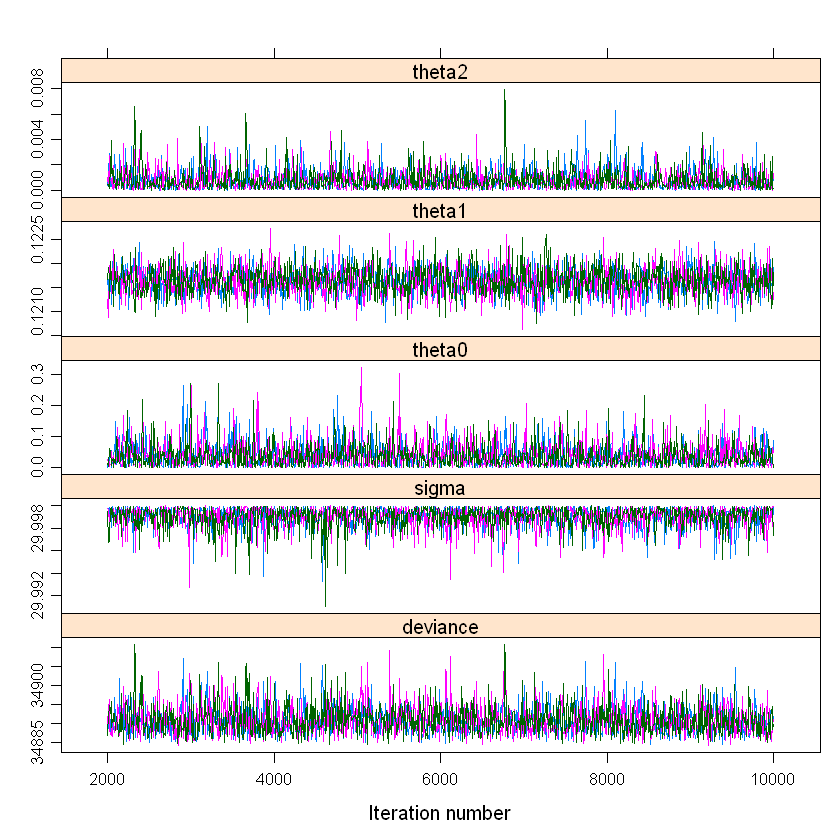

In [30]:
ex3.NIP.mcmc<-as.mcmc(ex3.NIP.jags)
xyplot(ex3.NIP.mcmc)

Recall that when performing an MCMC procedure, the algorithm tries to stay at places where probability is higher. According to this and looking at the graph, we can see that for $\theta_0$, $\theta_2$ and $\sigma$ priors were inadequate. Notice that, in the three cases, the traceplot seems to have been cut. For instance, for the $\theta_0$ case, we see that MCMC tries to stay at places close to 0. However, we are not allowing the "goat" to explore negative numbers of the parameter space because we are limitting its support to take numbers from 0 to 1 by taking a $\text{U}[0,1]$ (i.e. taking a NIP). The same happens for $\theta_2$.

Let us look at the summary of the posterior distribution of each parameter:

In [31]:
summary(ex3.NIP.mcmc)


Iterations = 2001:9993
Thinning interval = 8 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

              Mean        SD  Naive SE Time-series SE
deviance 3.489e+04 3.7758350 6.894e-02      7.195e-02
sigma    3.000e+01 0.0009551 1.744e-05      1.914e-05
theta0   4.014e-02 0.0399237 7.289e-04      7.893e-04
theta1   1.216e-01 0.0002925 5.340e-06      5.338e-06
theta2   7.946e-04 0.0008155 1.489e-05      1.663e-05

2. Quantiles for each variable:

              2.5%       25%       50%       75%     97.5%
deviance 3.489e+04 3.489e+04 3.489e+04 3.489e+04 3.490e+04
sigma    3.000e+01 3.000e+01 3.000e+01 3.000e+01 3.000e+01
theta0   1.065e-03 1.165e-02 2.792e-02 5.566e-02 1.439e-01
theta1   1.211e-01 1.214e-01 1.216e-01 1.218e-01 1.222e-01
theta2   2.050e-05 2.244e-04 5.393e-04 1.120e-03 2.955e-03


Since we are forcing those parameters whose priors were inadequate to stay between ranges with lower probability, the estimated mean for $\theta_0$, for instance, is close to 0. 

Let's now do the same experiment taking normal distributions as priors for our parameters despite $\sigma$, which we will still keep the NIP:

In [47]:
N<-length(row.names(df))

cat("model {for (i in 1:N){ 
                y[i] ~ dnorm(y.hat[i], tau)
                y.hat[i] <- theta0 + theta1 * x1[i] + theta2 * x2[i] 
                }

            theta0 ~ dnorm(-385.18,1/19.46) 
            theta1 ~ dnorm(0.26,1/0.006)
            theta2 ~ dnorm(-7.66,1/0.385)
            tau <- pow(sigma, -2)
            sigma ~ dunif(0,30)  
            } ",file="ex3.prior.normal")
ex3.prior.normal <- list("x2" = df$Income, "x1" = df$Limit, "y" = df$Balance, "N" = N)

In [48]:
ex3.prior.normal.JAGS <-jags(data=ex3.prior.normal, n.chains=3,
        parameters.to.save=c("theta0", "theta1", "theta2", "sigma"), 
        model.file="ex3.prior.normal",n.iter=10000,n.burnin=2000)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 400
   Unobserved stochastic nodes: 4
   Total graph size: 2408

Initializing model



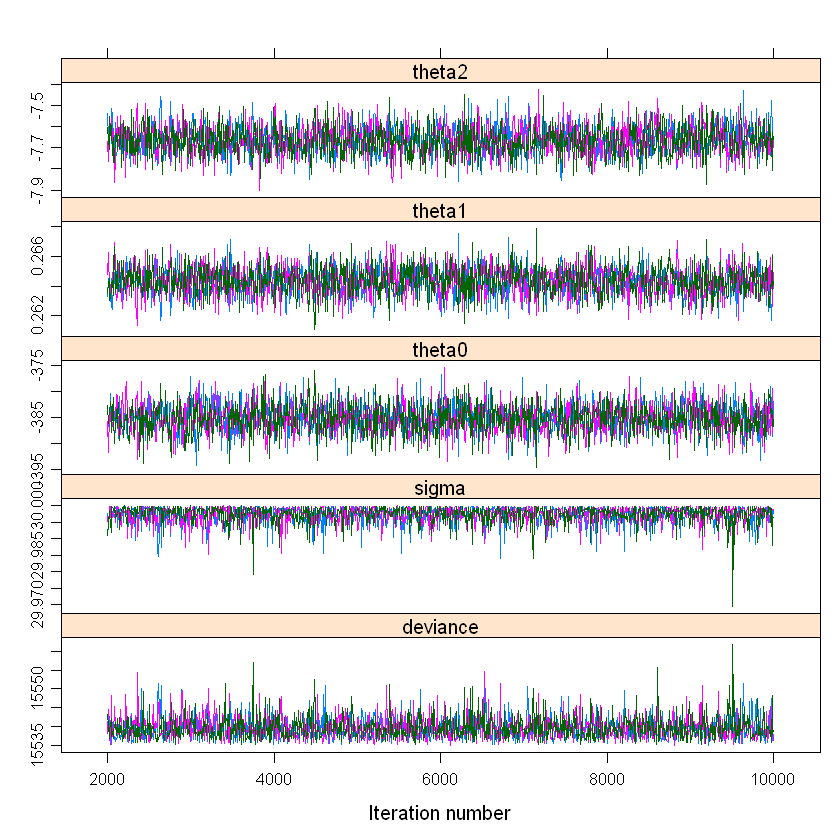

In [49]:
ex3.prior.normal.mcmc <- as.mcmc(ex3.prior.normal.JAGS)
xyplot(ex3.prior.normal.mcmc)

In this case, MCMC results are more optimistic that the other ones because, as you can see, now, the "goat" is able the explore the places with higher probabilities. In all cases, despite the $\sigma$ parameter, $\theta_0$, $\theta_1$ and $\theta_2$ explore the parameter space with success. Therefore, we should consider choosing another prior for $\sigma$.

In [50]:
summary(ex3.prior.normal.mcmc)


Iterations = 2001:9993
Thinning interval = 8 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

               Mean        SD  Naive SE Time-series SE
deviance 15539.5169 2.9516594 5.389e-02      5.384e-02
sigma       29.9974 0.0025543 4.663e-05      4.971e-05
theta0    -385.2109 2.8431877 5.191e-02      5.304e-02
theta1       0.2643 0.0009676 1.767e-05      1.808e-05
theta2      -7.6640 0.0696131 1.271e-03      1.301e-03

2. Quantiles for each variable:

               2.5%        25%        50%       75%      97.5%
deviance 15535.6337 15537.3840 15538.9070 15541.049 15546.8438
sigma       29.9906    29.9964    29.9981    29.999    29.9999
theta0    -390.8066  -387.0585  -385.2395  -383.302  -379.5152
theta1       0.2624     0.2637     0.2643     0.265     0.2662
theta2      -7.7988    -7.7114    -7.6643    -7.618    -7.5260


Let's look at the posterior distributions for those parameters:

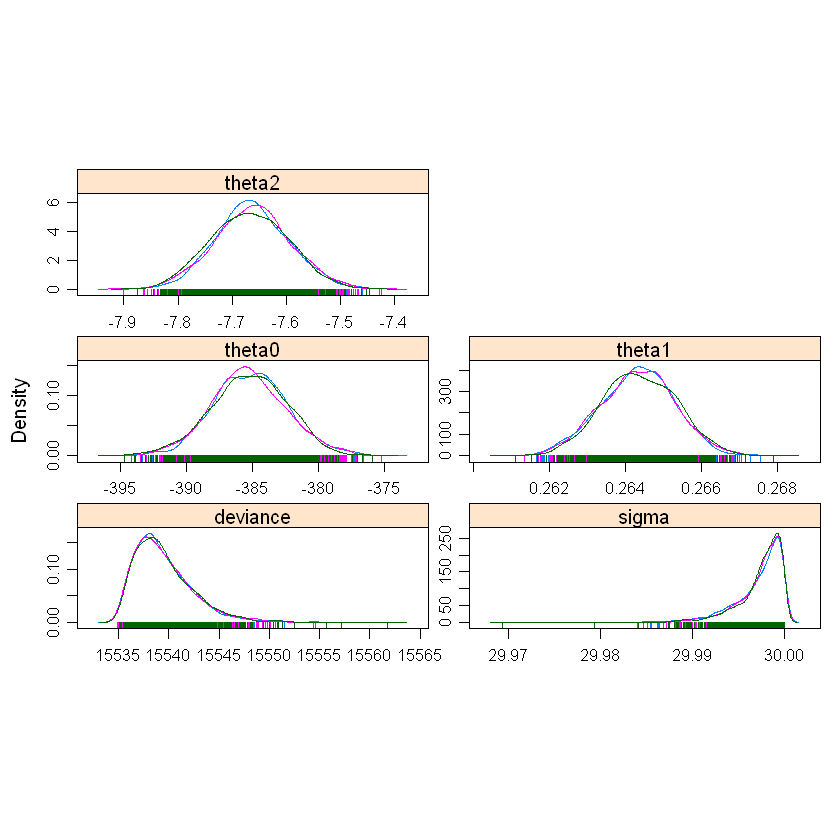

In [53]:
densityplot(ex3.prior.normal.mcmc)

Let's now move to the second model we fitted:

$$\text{Balance} = \beta_0 + \beta_1 \text{Student} + \beta_2 \text{Limit} + u$$

whose summary was:

In [15]:
summary(Credit.lm2)


Call:
lm(formula = Balance ~ Student + Limit, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-637.77 -116.90    6.04  130.92  434.24 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -3.347e+02  2.307e+01  -14.51   <2e-16 ***
StudentYes   4.044e+02  3.328e+01   12.15   <2e-16 ***
Limit        1.720e-01  4.331e-03   39.70   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 199.7 on 397 degrees of freedom
Multiple R-squared:  0.8123,	Adjusted R-squared:  0.8114 
F-statistic: 859.2 on 2 and 397 DF,  p-value: < 2.2e-16


We need to perform the following change to enable JAGS and Stan to understand our data:

In [8]:
StudentYes <- ifelse(df$Student == "Yes", 1, 0)

We'll also use both a uniform NIP and a normal prior, as before. Beggining with the NIP case:

In [26]:
N<-length(row.names(df))

cat("model {for (i in 1:N){ 
                y[i] ~ dnorm(y.hat[i], tau)
                y.hat[i] <- theta0 + theta1 * x1[i] + theta2 * x2[i] 
                }

            theta0 ~ dunif(0,1) 
            theta1 ~ dunif(0,1) 
            theta2 ~ dunif(0,1) 
            tau <- pow(sigma, -2) 
            sigma ~ dunif(0,30)  
            } ",file="ex3NIP_2.jag")
ex3.NIP <- list("x2" = df$Limit, "x1" = StudentYes, "y" = df$Balance, "N" = N)

In [31]:
ex3.NIP.jags<-jags(data=ex3.NIP, n.chains=3,
        parameters.to.save=c("theta0", "theta1", "theta2", "sigma"), 
        model.file="ex3NIP_2.jag",n.iter=10000,n.burnin=2000)
ex3.NIP.mcmc<-as.mcmc(ex3.NIP.jags)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 400
   Unobserved stochastic nodes: 4
   Total graph size: 1990

Initializing model



ERROR: Error in UseMethod("xyplot"): no applicable method for 'xyplot' applied to an object of class "list"


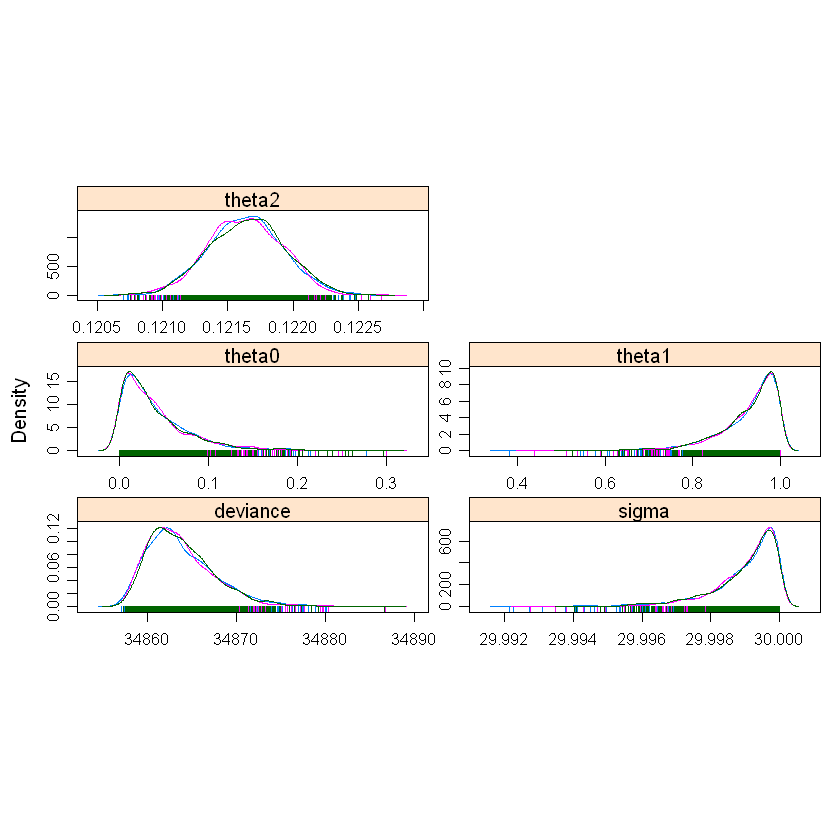

In [46]:
densityplot(ex3.NIP.mcmc)

Similar behaviour occurs with the NIP case for the second model. Hopefully, we will fix this problem using normal priors:

In [60]:
N<-length(row.names(df))

cat("model {for (i in 1:N){ 
                y[i] ~ dnorm(y.hat[i], tau)
                y.hat[i] <- theta0 + theta1 * x1[i] + theta2 * x2[i] 
                }

            theta0 ~ dnorm(-334.7,1/23.07) 
            theta1 ~ dnorm(404.4,1/33.28)
            theta2 ~ dnorm(0.172,1/0.00433)
            tau <- pow(sigma, -2) 
            sigma ~ dunif(0,30)  
            } ",file="ex3.prior.normal_2")
ex3.prior.normal <- list("x2" = df$Limit, "x1" = StudentYes, "y" = df$Balance, "N" = N)

In [61]:
ex3.prior.normal.JAGS <-jags(data=ex3.prior.normal, n.chains=3,
        parameters.to.save=c("theta0", "theta1", "theta2", "sigma"), 
        model.file="ex3.prior.normal_2",n.iter=10000,n.burnin=2000)
ex3.prior.normal.mcmc <- as.mcmc(ex3.prior.normal.JAGS)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 400
   Unobserved stochastic nodes: 4
   Total graph size: 2000

Initializing model



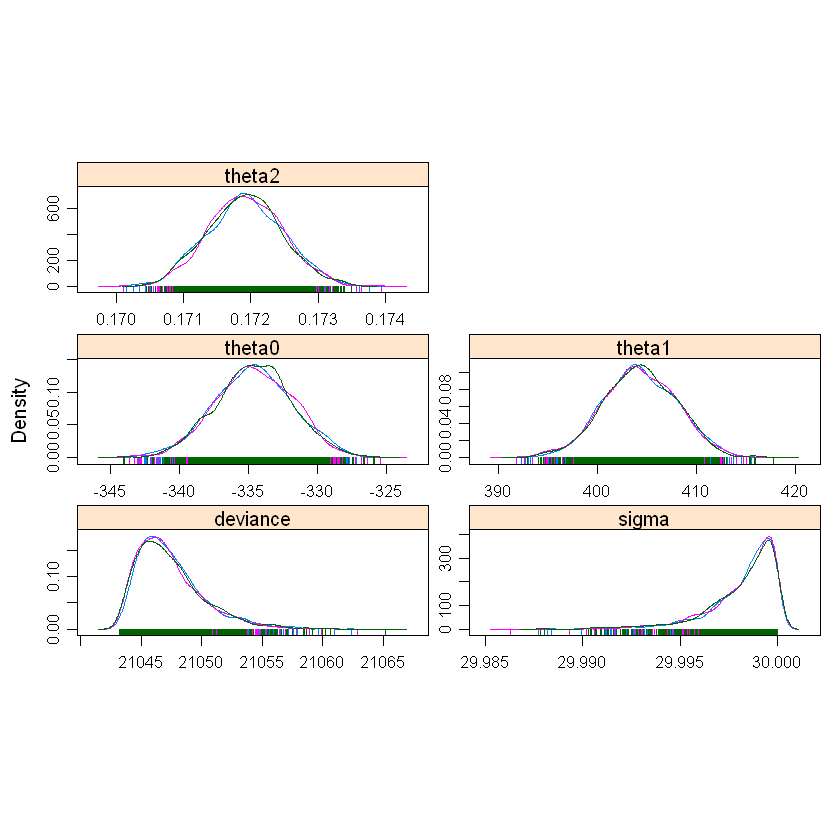

In [62]:
densityplot(ex3.prior.normal.mcmc)

Posterior distributions for parameters $\theta$ are much accurate than before. Conclusions are the same as in the first model.

#### (2) Same as above with Stan.

Let's first tune the settings of the Stan as recommended:

In [99]:
options(mc.cores = parallel::detectCores())
library("rstan")
rstan_options(auto_write = TRUE)

As we have been doing, we will stick to the two different priors we have been using, the NIP and the normal one. However, since we saw that taking a $\text{U}(0,30)$ for $\sigma$ was not the best decision we could make (recall that it seemed that $\sigma$ would be higher than 30), we will change this prior to a $\text{Gamma}(100, 1)$. The support of this distribution is from $0$ to $\infty$, which supports our choice since $\sigma$ can't be negative. With this prior, the $\text{E}(\sigma)=\frac{\alpha}{\beta}\frac{100}{1}=100$.

NIP case:

1. __Likelihood:__ $ \quad \text{Balance} \sim \text{N} (\widehat{\text{Balance}}, \sigma)$
2. __Prior $\theta$:__$\quad \theta_i \sim \text{U}(0,1) \quad \text{for} \quad i = 0,1,2$
3. __Prior $\sigma$:__ $\sigma \sim \text{Gamma}(100,1)$

Normal prior case:

1. __Likelihood:__ $ \quad \text{Balance} \sim \text{N} (\widehat{\text{Balance}}, \sigma)$
2. __Prior $\theta$:__$\quad \theta_i \sim \text{N}(\hat{\theta_i}, \hat{\text{SE}}) \quad \text{for} \quad i = 0,1,2$
3. __Prior $\sigma$:__ $\sigma \sim \text{Gamma}(100,1)$

Let's start with the NIP:

In [307]:
N<-length(row.names(df))

stan.model1.NIP.string<-"
    data{
    int<lower=1> N;
    vector[N] x1;
    vector[N] x2;
    vector[N] y; 
    }
    parameters{
    real theta0;
    real theta1;
    real theta2;
    real<lower=0> sigma;
    }
    model{ 
        vector[N] y_hat;
        y_hat = theta0 + theta1*x1 + theta2*x2; 
        y~normal(y_hat,sigma);
        theta0 ~ uniform(0,1);
        theta1 ~ uniform(0,1);
        theta2 ~ uniform(0,1);
        sigma ~ gamma(100,1);
        }
"
cat(stan.model1.NIP.string, file="stan.model1.NIP.stan")

In [308]:
stan.model1.NIP.dat <-list(y = df$Balance, x1 = df$Limit, x2 = df$Income, N = N)

We'll keep the 3 chains, burning the first 1500 simulations at each chain:

In [309]:
nChains<-3
burnInSteps<-1500
numSavedSteps<-6000  #across all chains
nIter<-ceiling(burnInSteps + numSavedSteps/nChains)

In [310]:
stan.model1.NIP<-stan(file="stan.model1.NIP.stan",
                                data=stan.model1.NIP.dat, 
                                chains=nChains,
                                iter=nIter,
                                warmup = burnInSteps,
                                control=list(max_treedepth=15, adapt_delta=0.99), # added after warning
                                save_dso=TRUE)

hash mismatch so recompiling; make sure Stan code ends with a blank line
Warning message in .local(object, ...):
"some chains had errors; consider specifying chains = 1 to debug"here are whatever error messages were returned


[[1]]
Stan model 'stan.model1' does not contain samples.



Warning message:
"There were 3664 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"

Some error has risen during the simulation. It seems that the simulation using the Hamiltonian method is not converging at all. This is due to the Non-Informative Priors we have chosen. Let's plot the trace to ensure our hypothesis of no convergence:

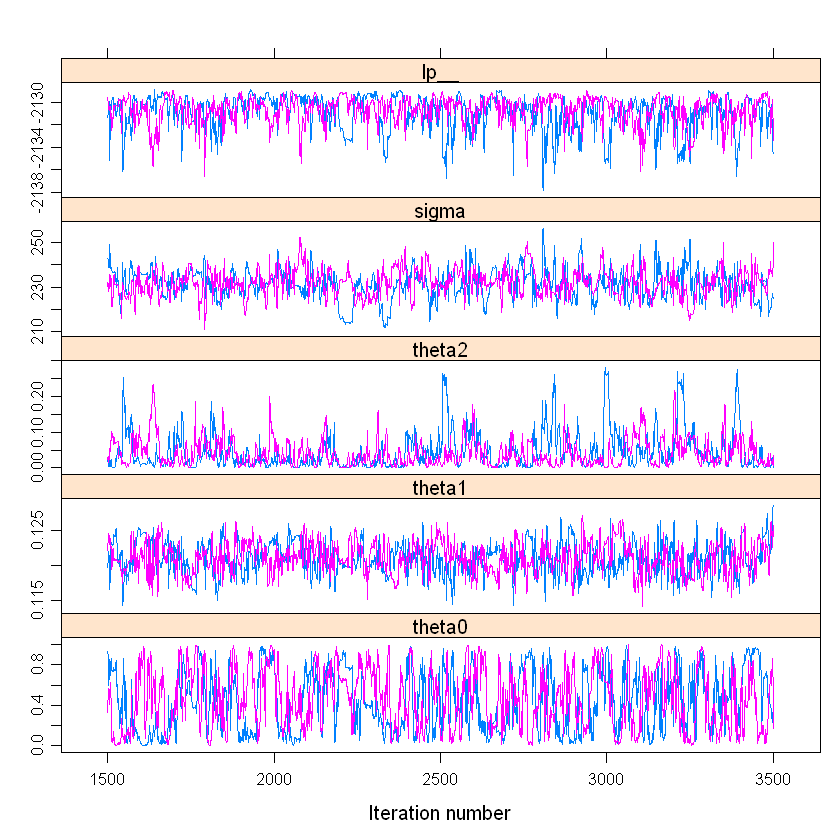

In [311]:
stan.model1.NIP.mcmc<-As.mcmc.list(stan.model1.NIP)
xyplot(stan.model1.NIP.mcmc)

In [312]:
print(stan.model1.NIP)

Inference for Stan model: stan.model1.
2 chains, each with iter=3500; warmup=1500; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=4000.

           mean se_mean   sd     2.5%      25%      50%      75%    97.5% n_eff
theta0     0.45    0.02 0.30     0.02     0.18     0.43     0.71     0.96   183
theta1     0.12    0.00 0.00     0.12     0.12     0.12     0.12     0.13   287
theta2     0.04    0.00 0.05     0.00     0.01     0.03     0.06     0.17   166
sigma    231.50    0.41 6.27   218.06   227.69   231.64   235.33   243.78   231
lp__   -2130.83    0.09 1.40 -2134.67 -2131.50 -2130.48 -2129.80 -2129.16   232
       Rhat
theta0 1.01
theta1 1.00
theta2 1.04
sigma  1.00
lp__   1.02

Samples were drawn using NUTS(diag_e) at Fri Jan 04 17:55:27 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In some cases, one chain is sometimes broken due to bad-luck initial points. Moreover, the traceplot is not encouraging at all. It isn't able to achieve stability and it does not travel along all the parameter space. Looking at the summary of the posterior distributions, we can see that means are between 0 and 1, of course, because we have limited that parameter space choosing that prior. The same thing happens using JAGS.

Using the actual priors we have:

In [313]:
N<-length(row.names(df))

stan.model1.string<-"
    data{
    int<lower=1> N;
    vector[N] x1;
    vector[N] x2;
    vector[N] y; 
    }
    parameters{
    real theta0;
    real theta1;
    real theta2;
    real<lower=0> sigma;
    }
    model{ 
        vector[N] y_hat;
        y_hat = theta0 + theta1*x1 + theta2*x2; 
        y~normal(y_hat,sigma);
        theta0 ~ normal(-385.18,19.46);
        theta1 ~ normal(0.26,0.006);
        theta2 ~ normal(-7.66,0.385);
        sigma ~ gamma(100,1);
        }
"
cat(stan.model1.string, file="stan.model1.stan")

In [316]:
stan.model1.dat <-list(y = df$Balance, x1 = df$Limit, x2 = df$Income, N = N)
nChains<-3
burnInSteps<-1500
numSavedSteps<-6000  #across all chains
nIter<-ceiling(burnInSteps + numSavedSteps/nChains)
stan.model1<-stan(file="stan.model1.stan",
                                data=stan.model1.dat, 
                                chains=nChains,
                                iter=nIter,
                                warmup = burnInSteps,
                                control=list(max_treedepth=15, adapt_delta=0.99), # added after warning
                                save_dso=TRUE)

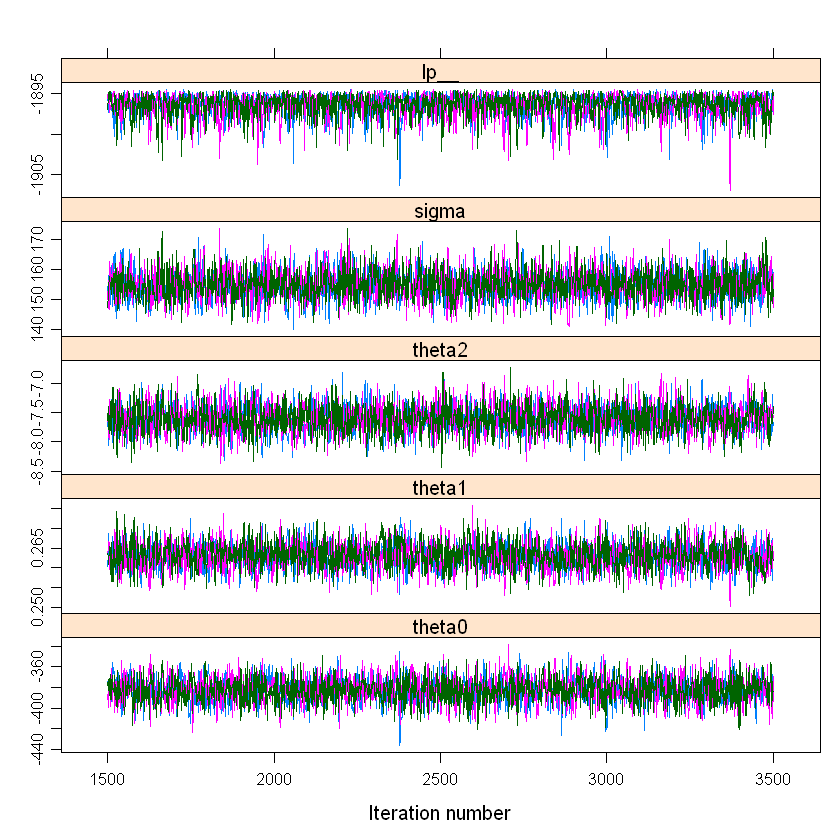

In [317]:
stan.model1.mcmc<-As.mcmc.list(stan.model1)
xyplot(stan.model1.mcmc)

In [318]:
print(stan.model1)

Inference for Stan model: stan.
3 chains, each with iter=3500; warmup=1500; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=6000.

           mean se_mean    sd     2.5%      25%      50%      75%    97.5%
theta0  -382.41    0.22 12.22  -406.46  -390.61  -382.27  -374.18  -358.78
theta1     0.26    0.00  0.00     0.26     0.26     0.26     0.27     0.27
theta2    -7.60    0.00  0.24    -8.06    -7.77    -7.60    -7.44    -7.13
sigma    155.04    0.08  4.89   145.66   151.61   154.90   158.31   164.91
lp__   -1896.44    0.03  1.41 -1899.93 -1897.13 -1896.13 -1895.40 -1894.69
       n_eff Rhat
theta0  2989    1
theta1  2573    1
theta2  3147    1
sigma   3522    1
lp__    2082    1

Samples were drawn using NUTS(diag_e) at Fri Jan 04 18:02:01 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Now, the MCMC works much better and we are able to find much more reasonable posterior distributions for $\theta$ and $\sigma$. We could also call `densityplot` for the estimated posterior using MCMC simulation. We can see that this analysis is not robust to the choice of the prior.
Performing the same analysis for the second model:

In [323]:
N<-length(row.names(df))

stan.model2.NIP.string<-"
    data{
    int<lower=1> N;
    vector[N] x1;
    vector[N] x2;
    vector[N] y; 
    }
    parameters{
    real theta0;
    real theta1;
    real theta2;
    real<lower=0> sigma;
    }
    model{ 
        vector[N] y_hat;
        y_hat = theta0 + theta1*x1 + theta2*x2; 
        y~normal(y_hat,sigma);
        theta0 ~ uniform(0,1);
        theta1 ~ uniform(0,1);
        theta2 ~ uniform(0,1);
        sigma ~ gamma(100,1);
        }
"
cat(stan.model2.NIP.string, file="stan.model2.NIP.stan")

In [329]:
stan.model2.NIP.dat <-list(y = df$Balance, x1 = StudentYes, x2 = df$Limit, N = N)
nChains<-3
burnInSteps<-1500
numSavedSteps<-6000  #across all chains
nIter<-ceiling(burnInSteps + numSavedSteps/nChains)

stan.model2.NIP<-stan(file="stan.model2.NIP.stan",
                                data=stan.model2.NIP.dat, 
                                chains=nChains,
                                iter=nIter,
                                warmup = burnInSteps,
                                control=list(max_treedepth=15, adapt_delta=0.99), # added after warning
                                save_dso=TRUE)

Warning message:
"There were 5207 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"

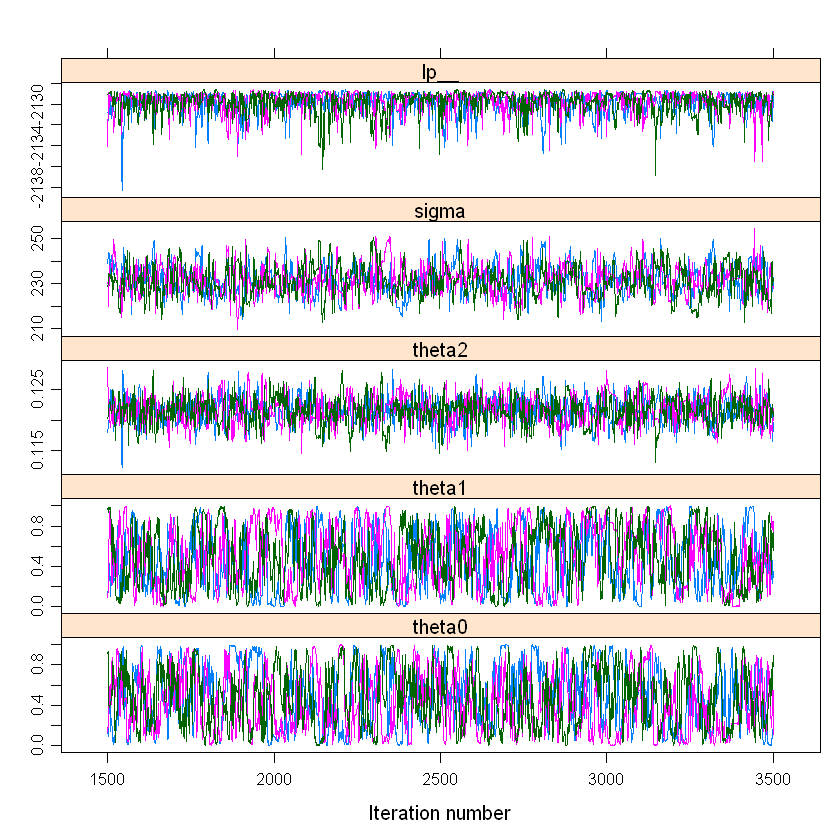

In [330]:
stan.model2.NIP.mcmc<-As.mcmc.list(stan.model2.NIP)
xyplot(stan.model2.NIP.mcmc)

In [331]:
print(stan.model2.NIP)

Inference for Stan model: stan.model2.
3 chains, each with iter=3500; warmup=1500; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=6000.

           mean se_mean   sd     2.5%      25%      50%      75%    97.5% n_eff
theta0     0.46    0.02 0.29     0.02     0.20     0.44     0.69     0.98   361
theta1     0.49    0.02 0.29     0.02     0.23     0.49     0.74     0.97   345
theta2     0.12    0.00 0.00     0.12     0.12     0.12     0.12     0.13  1021
sigma    231.54    0.26 6.55   218.79   227.14   231.44   235.77   244.80   656
lp__   -2129.86    0.04 1.02 -2132.53 -2130.27 -2129.56 -2129.15 -2128.78   829
       Rhat
theta0 1.01
theta1 1.01
theta2 1.00
sigma  1.00
lp__   1.00

Samples were drawn using NUTS(diag_e) at Fri Jan 04 18:31:07 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


We see a similar behaviour than before. And, using the normal priors:

In [9]:
N<-length(row.names(df))

stan.model2.string<-"
    data{
    int<lower=1> N;
    vector[N] x1;
    vector[N] x2;
    vector[N] y; 
    }
    parameters{
    real theta0;
    real theta1;
    real theta2;
    real<lower=0> sigma;
    }
    model{ 
        vector[N] y_hat;
        y_hat = theta0 + theta1*x1 + theta2*x2; 
        y~normal(y_hat,sigma);
        theta0 ~ normal(-334.7,23.07);
        theta1 ~ normal(404.4,33.28);
        theta2 ~ normal(0.172,0.00433);
        sigma ~ gamma(100,1);
        }
"
cat(stan.model2.string, file="stan.model2.stan")

In [10]:
stan.model2.dat <-list(y = df$Balance, x1 = StudentYes, x2 = df$Limit, N = N)
nChains<-3
burnInSteps<-1500
numSavedSteps<-6000  #across all chains
nIter<-ceiling(burnInSteps + numSavedSteps/nChains)

stan.model2<-stan(file="stan.model2.stan",
                                data=stan.model2.dat, 
                                chains=nChains,
                                iter=nIter,
                                warmup = burnInSteps,
                                control=list(max_treedepth=15, adapt_delta=0.99), # added after warning
                                save_dso=TRUE)


SAMPLING FOR MODEL 'stan' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3500 [  0%]  (Warmup)
Chain 1: Iteration:  350 / 3500 [ 10%]  (Warmup)
Chain 1: Iteration:  700 / 3500 [ 20%]  (Warmup)
Chain 1: Iteration: 1050 / 3500 [ 30%]  (Warmup)
Chain 1: Iteration: 1400 / 3500 [ 40%]  (Warmup)
Chain 1: Iteration: 1501 / 3500 [ 42%]  (Sampling)
Chain 1: Iteration: 1850 / 3500 [ 52%]  (Sampling)
Chain 1: Iteration: 2200 / 3500 [ 62%]  (Sampling)
Chain 1: Iteration: 2550 / 3500 [ 72%]  (Sampling)
Chain 1: Iteration: 2900 / 3500 [ 82%]  (Sampling)
Chain 1: Iteration: 3250 / 3500 [ 92%]  (Sampling)
Chain 1: Iteration: 3500 / 3500 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 26.215 seconds (Warm-up)
Chain 1:                2.662 seconds (Sampling)
Chain 1:                28.877 seconds (

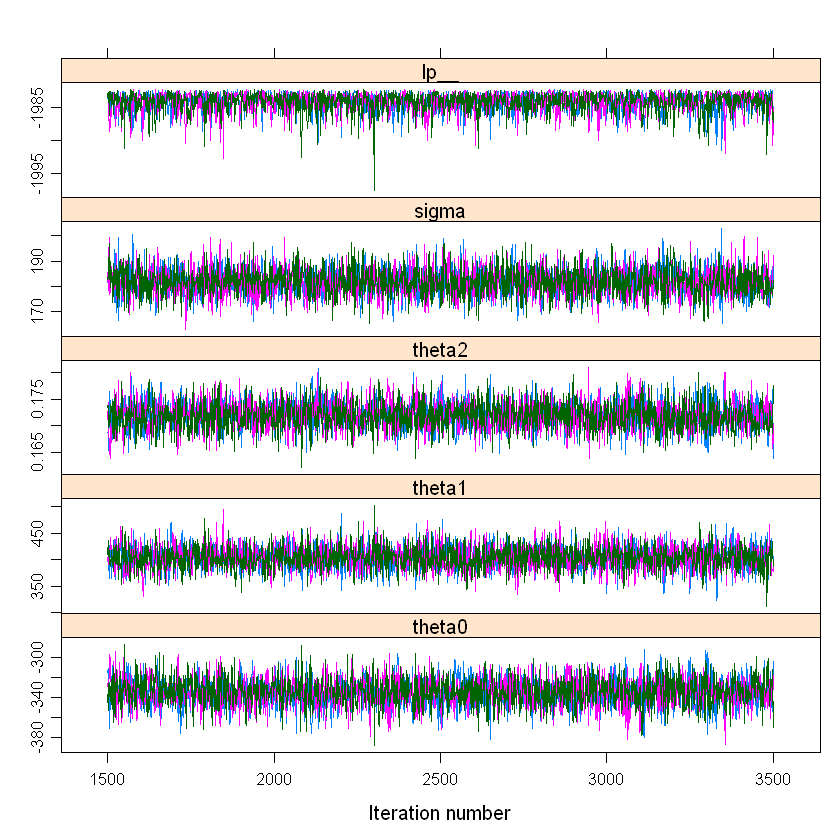

In [12]:
stan.model2.mcmc<-As.mcmc.list(stan.model2)
xyplot(stan.model2.mcmc)

In [341]:
print(stan.model2)

Inference for Stan model: stan.
3 chains, each with iter=3500; warmup=1500; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=6000.

           mean se_mean    sd     2.5%      25%      50%      75%    97.5%
theta0  -334.59    0.26 13.33  -361.46  -343.34  -334.41  -325.71  -308.66
theta1   404.12    0.36 22.23   360.74   388.91   404.33   419.08   447.43
theta2     0.17    0.00  0.00     0.17     0.17     0.17     0.17     0.18
sigma    181.86    0.08  5.40   171.49   178.13   181.73   185.50   192.61
lp__   -1984.13    0.03  1.42 -1987.66 -1984.80 -1983.80 -1983.08 -1982.36
       n_eff Rhat
theta0  2728    1
theta1  3804    1
theta2  3476    1
sigma   4039    1
lp__    1894    1

Samples were drawn using NUTS(diag_e) at Fri Jan 04 18:36:48 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Again, results seem much better than were before. Conclusions regarding the whole analysis using JAGS and Stan are presented at the end of this exercise.

#### (4) Assuming given $\text{Limit}=3000$ and $\text{Income}=22$, simulate the posterior predictive pdf of Balance with the first model. Similarly for the second model for a student with  $\text{Limit}=3000$ and for a non-student with the same $\text{Limit}$ value.

Let's begin with the first model. Recall that we saved the summaries for the linear models fitted at the 1st section. We have to obtain the estimated balance for a person with those characteristics ($\widehat{\text{Balance}}$) which is equal to:

$$\widehat{\text{Balance}} = \hat{\beta_0} + \hat{\beta_1} \text{Limit} + \hat{\beta_2} \text{Income}$$
$$\widehat{\text{Balance}} = -385.18 + 0.264* \text{Limit} + -7.66* \text{Income}$$

For the second model, for a Student, we can calculate the estimated mean balance as:

$$\widehat{\text{Balance}} = \hat{\beta_0} + \hat{\beta_1} \text{StudentYes} + \hat{\beta_2} \text{Limit}$$

whereas, for a non-student, the estimate is of balance can be computed as:

$$\widehat{\text{Balance}} = \hat{\beta_0} + \hat{\beta_2} \text{Limit}$$

since `StudentYes` would be equal to 0.

Let's compute all those numbers:

In [133]:
s1 <- summary(Credit.lm1)
s2 <- summary(Credit.lm2)

balance.hat <- s1$coef[1,1]+s1$coef[2,1]*3000+s1$coef[3,1]*22
balance.hat

balance.hat1 <- s2$coef[1,1]+s2$coef[2,1]+s2$coef[3,1]*3000
balance.hat1

balance.hat2 <- s2$coef[1,1]+s2$coef[3,1]*3000
balance.hat2

[1] 239.1923

[1] 585.5352

[1] 181.1316

Therefore:
- For a person with 3,000 dollars as Limit and 22,000 dollars as Income, $\widehat{\text{Balance}}=239.19$.
- For a student with 3,000 dollars as Limit, $\widehat{\text{Balance}}=585.54$.
- For a person with 3,000 dollars as Limit and 22,000 dollars as Income, $\widehat{\text{Balance}}=181.13$.

We have added a line to the JAGS code. Recall that we assumed that `Balance` followed a normal distribution. Therefore, `Balance.pred` will be following also normal distribution (recall that it was not intuitive, explained above). The mean of this normal will be the estimate for `Balance` and the dispersion measure is the same as in our likelihood.

Since we want to find out how the credit card average balance of a person with those characteristics is distributed:

In [121]:
N<-length(row.names(df))

cat("model {for (i in 1:N){ 
                y[i] ~ dnorm(y.hat[i], tau)
                y.hat[i] <- theta0 + theta1 * x1[i] + theta2 * x2[i] 
                }
            
            theta0 ~ dnorm(-385.18,1/19.46) 
            theta1 ~ dnorm(0.26,1/0.006)
            theta2 ~ dnorm(-7.66,1/0.385)
            tau <- pow(sigma, -2)
            sigma ~ dgamma(100,1)  
            balance.pred ~ dnorm(239.19, tau)
            } ",file="ex3.postpred.jag")
ex3.post.pred <- list("x2" = df$Income, "x1" = df$Limit, "y" = df$Balance, "N" = N)

In [122]:
ex3.post.pred.JAGS <-jags(data=ex3.post.pred, n.chains=3,
        parameters.to.save=c("theta0", "theta1", "theta2", "sigma", "balance.pred"), 
        model.file="ex3.postpred.jag",n.iter=10000,n.burnin=2000)
ex3.post.pred.mcmc <- as.mcmc(ex3.post.pred.JAGS)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 400
   Unobserved stochastic nodes: 5
   Total graph size: 2409

Initializing model



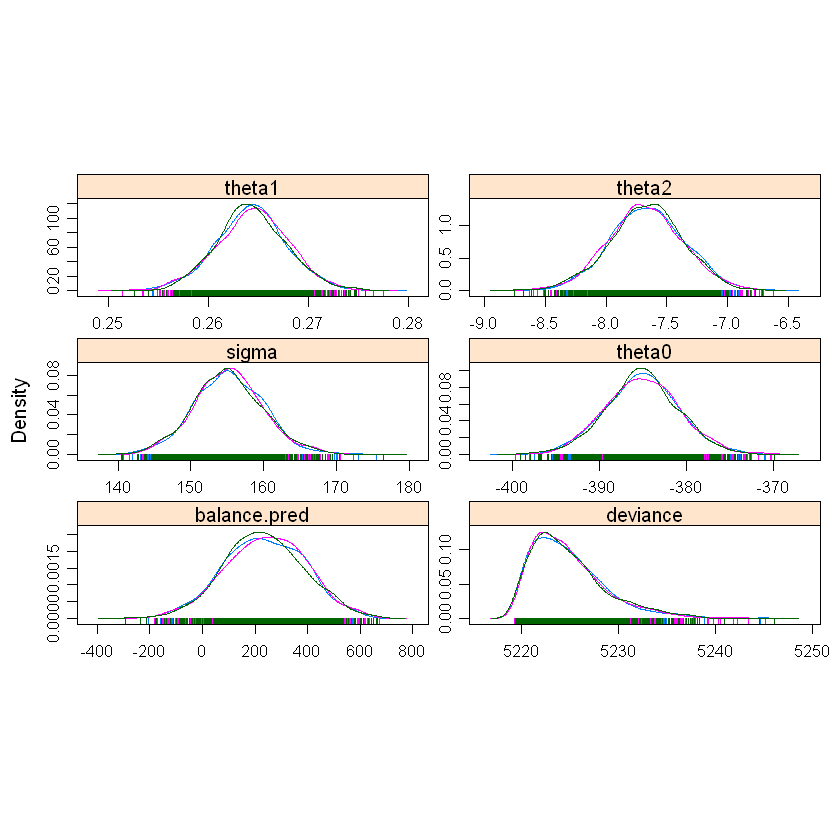

In [126]:
densityplot(ex3.post.pred.mcmc)

We are interested in the `balance.pred` graph. Let's look at the summary of that variable:

In [127]:
summary(ex3.prior.normal.mcmc)


Iterations = 2001:9993
Thinning interval = 8 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                  Mean        SD  Naive SE Time-series SE
balance.pred  236.4118 1.541e+02 2.813e+00      2.811e+00
deviance     5224.9827 3.854e+00 7.037e-02      7.091e-02
sigma         155.1664 4.759e+00 8.689e-02      8.517e-02
theta0       -385.2427 4.299e+00 7.850e-02      7.850e-02
theta1          0.2643 3.512e-03 6.413e-05      6.414e-05
theta2         -7.6612 3.048e-01 5.566e-03      5.567e-03

2. Quantiles for each variable:

                  2.5%       25%       50%       75%     97.5%
balance.pred  -58.1331  129.2194  235.2421  340.5411  538.1760
deviance     5219.8380 5222.0788 5224.2054 5227.0266 5234.5005
sigma         146.0347  151.8527  155.0438  158.3725  164.9142
theta0       -393.6430 -388.1382 -385.2147 -382.3672 -376.7995
theta1          0.2578    0.2619    0.2643    0.

The MAP is $236.4$, which is sligthly slower than the frequentist estimate ($239.19$) for a 22,000 dollar person with a Credit Limit of 3,000 dollar. According to our model, this person will have, on average, more than $236 on his account.

Let's perform the same analysis for a person with \$3000 (either for students and for non-students). We'll add two lines this time, one for the students and the other for the non-students. The mean for `balance.pred` (non-students), this time will be $181.13$. On the other hand, `balance.pred.student` will be centered around $585.54$. 

In [138]:
N<-length(row.names(df))

cat("model {for (i in 1:N){ 
                y[i] ~ dnorm(y.hat[i], tau)
                y.hat[i] <- theta0 + theta1 * x1[i] + theta2 * x2[i] 
                }
            
            theta0 ~ dnorm(-385.18,1/19.46) 
            theta1 ~ dnorm(0.26,1/0.006)
            theta2 ~ dnorm(-7.66,1/0.385)
            tau <- pow(sigma, -2)
            sigma ~ dgamma(100,1)  
            balance.pred ~ dnorm(181.13, tau)
            balance.pred.student ~ dnorm(585.54, tau)
            } ",file="ex3.postpred1.jag")
ex3.post.pred1 <- list("x2" = df$Income, "x1" = StudentYes, "y" = df$Balance, "N" = N)

In [139]:
ex3.post.pred1.JAGS <-jags(data=ex3.post.pred1, n.chains=3,
        parameters.to.save=c("theta0", "theta1", "theta2", "sigma", "balance.pred", "balance.pred.student"), 
        model.file="ex3.postpred1.jag",n.iter=10000,n.burnin=2000)
ex3.post.pred1.mcmc <- as.mcmc(ex3.post.pred1.JAGS)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 400
   Unobserved stochastic nodes: 6
   Total graph size: 2026

Initializing model



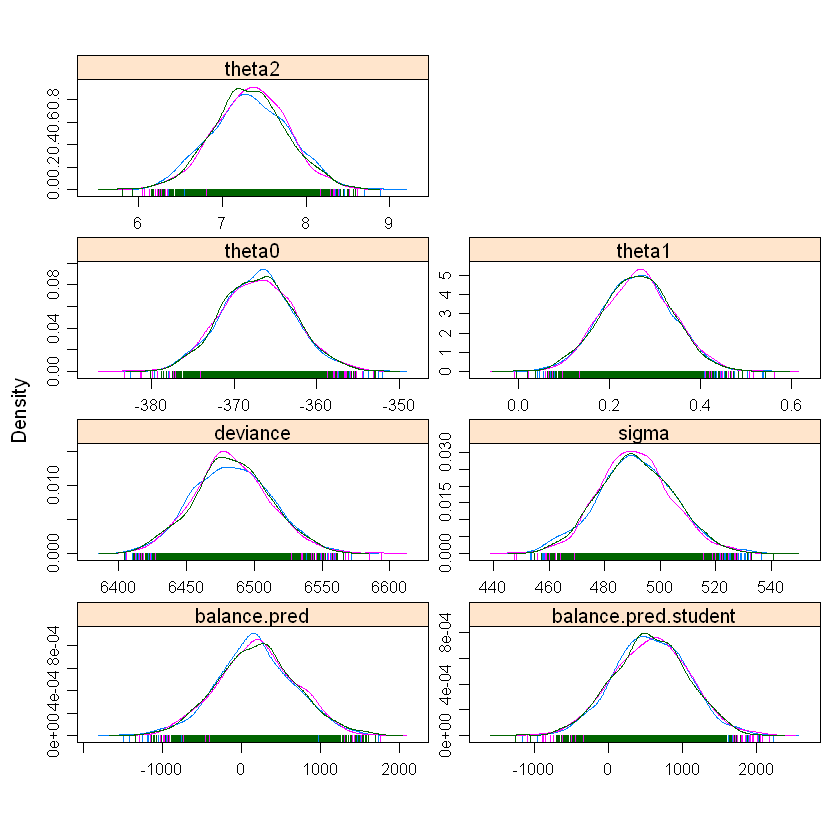

In [140]:
densityplot(ex3.post.pred1.mcmc)

In [141]:
summary(ex3.post.pred1.mcmc)


Iterations = 2001:9993
Thinning interval = 8 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                          Mean        SD Naive SE Time-series SE
balance.pred          190.1339 491.99499 8.982558       9.353788
balance.pred.student  574.7527 501.14771 9.149663       9.151774
deviance             6483.6068  28.26849 0.516110       0.516266
sigma                 491.1876  13.48720 0.246242       0.243691
theta0               -367.1262   4.41783 0.080658       0.080683
theta1                  0.2623   0.07724 0.001410       0.001371
theta2                  7.3310   0.44353 0.008098       0.008091

2. Quantiles for each variable:

                          2.5%       25%       50%       75%     97.5%
balance.pred         -785.0108 -132.6238  187.5760  512.2628 1169.9266
balance.pred.student -402.5447  235.7144  572.9168  916.9591 1546.4130
deviance             6429.0936 6464.

The posterior maximum for students is, in this draw, $574.75$, and, for non-students it was $190.13$. We can see that students tend to keep a higher balance on their account, compared to non-students which makes sense.

As a __conclusion__ for this exercise we can say that the prior chosen sometimes matter to achieve accurate results. We were comparing two different priors for $\theta$ and we also saw some priors for $\sigma$. Since we are estimating the posterior distribution for the parameters using a Markov Chain Montecarlo method we have to enable this method to explorate a reasonable paramater space, otherwise, we don't allow it to explore places with higher probabilities.

Regarding the estimated posterior distributions, we can see that the results are similar to the frequentist ones. This means that the hypothesis for normality on the distribution of $\theta$, in our example, is reasonable. It could had happened that we end up having a MAP not coinciding with the frequentist estimate $\hat{\theta}$ and on top of that, we could have had a non-symmetric posterior distribution, which is not the case. For example, in this last case:

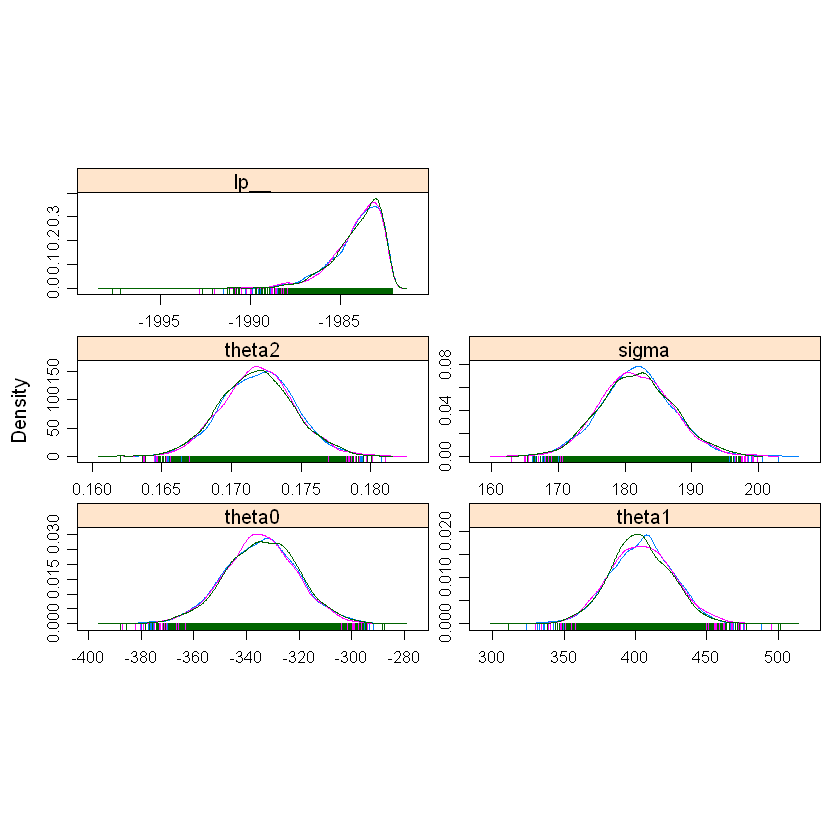

In [120]:
densityplot(stan.model2.mcmc)

We can see, as said, that posterior distributions for $\theta$ and $\sigma$ seem symmetric for the 3 chains performed. The same happens for the other estimated models. Therefore, posterior distributions after MCMC simulation seem to not fall in contradiction with our prior beliefs once we have observed some $x$.